In [127]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import aplpy
from astropy.io import fits
# from reproject import reproject_interp
# from astropy.constants import c, k_B, h

# import molecular_columns as mol_col

from scipy import stats
from config import file_NH3_Tex, file_NH3_eTex, file_NH3_Tkin, file_NH3_eTkin, \
    file_NH3_Ncol, file_NH3_eNcol, file_NH3_Vlsr, file_NH3_eVlsr, \
    file_NH3_dv,  file_NH3_edv

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in'})

In [110]:
file_NH3_TdV = 'data/H-MM1_NH3_11_TdV.fits'
file_NH3_22_TdV = 'data/H-MM1_NH3_22_TdV.fits'
file_H2 = 'data/H-MM1_NH2_6arcsec_aligned.fits'
file_model = 'data/Model_NH3_H2_3.2e5.dat'

N_H2, hd_H2 = fits.getdata(file_H2, header=True)
hd_H2['BMAJ'] = 6./3600.
hd_H2['BMIN'] = 6./3600.
hd_H2['BPA'] = 0.
hdu_H2 = fits.PrimaryHDU(N_H2/1e22, hd_H2)

tk = fits.getdata(file_NH3_Tkin)
elog_N_NH3 = fits.getdata(file_NH3_eNcol)
log_N_NH3, hd = fits.getdata(file_NH3_Ncol, header=True)

gd_col_dens = np.isfinite(log_N_NH3 / N_H2) * (N_H2 != 0.0)

N_NH3_14 = 10**(log_N_NH3 - 14.)
N_NH3_14_gd = N_NH3_14[gd_col_dens]
eN_NH3_14 = N_NH3_14 * np.log(10.) * elog_N_NH3
eN_NH3_14_gd = eN_NH3_14[gd_col_dens]
N_H2_22 = N_H2 * 1e-22
N_H2_22_gd = N_H2_22[gd_col_dens]

X_NH3_H2 = N_NH3_14/ N_H2_22
X_NH3_H2_gd = X_NH3_H2[gd_col_dens]
# NH3_H2 # NH3_H2 = 10**NH3_Ncol/N_H2 * 1e8
# gd_X_NH3_H2 =  np.isfinite(X_NH3_H2)

X_NH3_SD = 0.76
X_NH3_H2_mean = np.round(np.mean(X_NH3_H2_gd), decimals=2)
print('<[o-NH2D/H2]> = {0}'.format(X_NH3_H2_mean))

hdu_N_NH3_14 = fits.PrimaryHDU(N_NH3_14, hd)
hdu_NH3_H2_8 = fits.PrimaryHDU(X_NH3_H2, hd)

<[o-NH2D/H2]> = 2.7


In [84]:
range_N11 = [1.2, 11.5]
range_H2 = [0.0, 7]

xpos_lab1, ypos_lab1 = (0.65, 0.915)
xpos_lab2, ypos_lab2 = (0.65, 0.83)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

col_pos = [0.675, 0.7, 0.185, 0.025]

cont_NH3 = np.arange(1.5, 5.1, 0.75)

color_kde = ['#e41a1c', '#377eb8', '#a65628']
color_levels = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c',
                '#fd8d3c', '#fc4e2a', '#e31a1c', '#b10026']
color_levels2 = ['#deebf7', '#c6dbef', '#9ecae1', '#6baed6',
                 '#4292c6', '#2171b5', '#08519c', '#08306b']

sigma_levels = np.array([0.5, 1.0, 1.5, 2.0])
sigma_levels_l = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
filled_levels = np.hstack([0, sigma_levels])  # 9000 sigmas ~ np.inf
filled_levels_l = np.hstack([0, sigma_levels_l])  # 9000 sigmas ~ np.inf
levels_norm = np.exp(-0.5 * sigma_levels ** 2)[::-1]
levels_norm_f = np.exp(-0.5 * filled_levels ** 2)[::-1]
levels_norm_l = np.exp(-0.5 * filled_levels_l ** 2)[::-1]

In [91]:
distance = 145. # pc

def plot_setup_vla(fig_i, label_col='black', do_zoom=True, do_contour=True):
    fig_i.set_system_latex(True)
    fig_i.ticks.set_color(label_col)
    fig_i.set_nan_color('0.85')
    if do_zoom:
        fig_i.recenter(246.9954991667, -24.5577775, radius=80*(u.arcsec).to(u.deg))
    fig_i.add_beam(color=label_col)
    ang_size = (3e3 / distance)*u.arcsec
    fig_i.add_scalebar(ang_size, label='3,000 au', color=label_col)
    #
    fig_i.tick_labels.set_xformat('hh:mm:ss')
    fig_i.tick_labels.set_yformat('dd:mm')
    fig_i.ticks.set_length(6)
    fig_i.ax.tick_params(which='minor', length=3)
    fig_i.ticks.set_xspacing(4*15./3600.)
    fig_i.ticks.set_minor_frequency(4)
    #
    fig_i.axis_labels.set_xtext('Right Ascension (J2000)')
    fig_i.axis_labels.set_ytext('Declination (J2000)')
    if do_contour:
        fig_i.show_contour(file_NH3_TdV, levels=cont_NH3, colors='white', linewidths=1.5)
        fig_i.show_contour(file_NH3_TdV, levels=cont_NH3, colors='black', linewidths=1)
    return fig_i

def hmm1_kde(my_X, my_Y, ymin=0, ymax=2.5, xmin=-0.0002, xmax=0.0008, 
             get_XY=False):
#     ymin=0
#     ymax=2.5
#     xmin=-0.0002
#     xmax=0.0008
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([my_X, my_Y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    if get_XY == False:
        return Z
    else:
        return X, Y, Z

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


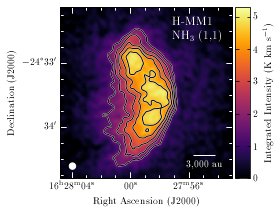

In [5]:
text_color = 'white'
fig = aplpy.FITSFigure(file_NH3_TdV, figsize=(4, 4))
fig.show_colorscale(vmin=0, vmax=5.3, cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_colorbar()
# fig_i.colorbar.set_ticks([0,40,80,120,160])
fig.colorbar.set_axis_label_text('Integrated Intensity (K km s$^{-1}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_TdV.pdf', dpi=200)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


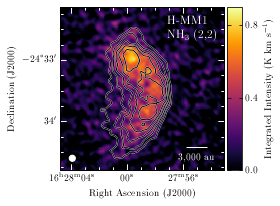

In [6]:
text_color = 'white'
fig = aplpy.FITSFigure(file_NH3_22_TdV, figsize=(4, 4))
fig.show_colorscale(vmin=0, vmax=0.9, cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (2,2)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_colorbar()
fig.colorbar.set_ticks([0, 0.4, 0.8])
fig.colorbar.set_axis_label_text('Integrated Intensity (K km s$^{-1}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_22_TdV.pdf', dpi=200)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  cm.set_bad(color)


INFO: Auto-setting vmax to  4.913e+00 [aplpy.core]


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


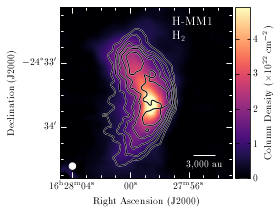

In [7]:
text_color = 'white'
fig = aplpy.FITSFigure(hdu_H2, figsize=(4, 4))
fig.show_colorscale(vmin=0, cmap='magma', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'H$_2$', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_colorbar()
fig.colorbar.set_ticks([0, 1, 2, 3, 4])
fig.colorbar.set_axis_label_text(r'Column Density ($\times$10$^{22}$ cm$^{-2}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_N_H2.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_59094/3463269698.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


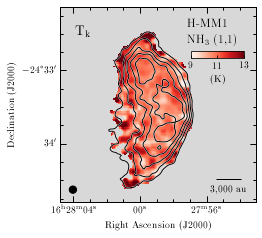

In [8]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_Tkin, figsize=(4, 4))
fig.show_colorscale(vmin=9., vmax=13., cmap='Reds', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'T$_{\rm k}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([9, 11, 13])
fig.colorbar.set_axis_label_text(r'(K)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Tkin.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues_r").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_59094/1134119013.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


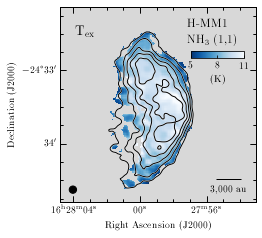

In [9]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_Tex, figsize=(4, 4))
fig.show_colorscale(vmin=5., vmax=11., cmap='Blues_r', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'T$_{\rm ex}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([5, 8, 11])
fig.colorbar.set_axis_label_text(r'(K)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Tex.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_59094/543608999.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


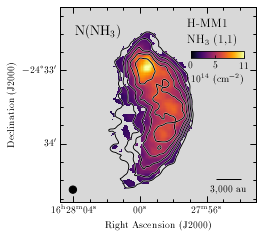

In [10]:
text_color = 'black'

fig = aplpy.FITSFigure(hdu_N_NH3_14, figsize=(4, 4))
fig.show_colorscale(vmin=0., vmax=11., cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'N(NH$_{3}$)', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([0, 5, 11])
fig.colorbar.set_axis_label_text(r'$10^{14}$ (cm$^{-2}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Ncol.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_59094/46978546.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


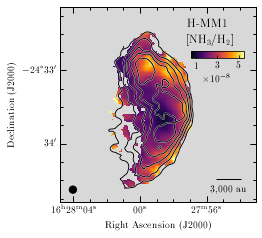

In [11]:
text_color = 'black'
fig = aplpy.FITSFigure(hdu_NH3_H2_8, figsize=(4, 4))
fig.show_colorscale(cmap='inferno', vmin=0.5, vmax=5.5, interpolation='None')
plot_setup_vla(fig, label_col=text_color) #  
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'[NH$_3$/H$_2$]', relative=True, 
                horizontalalignment='left', color=text_color, size=12)

fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_axis_label_text(r'$\times10^{-8}$')
fig.colorbar.set_ticks([1, 3, 5])

plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_H2_ratio.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


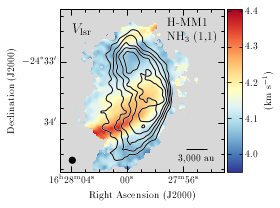

In [12]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_Vlsr, figsize=(4, 4))
fig.show_colorscale(vmin=3.95, vmax=4.405, cmap='RdYlBu_r', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'$V_{\rm lsr}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_ticks([4.0, 4.1, 4.2, 4.3, 4.4])
fig.colorbar.set_axis_label_text(r'(km s$^{-1}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Vlsr.pdf', dpi=100)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greens").copy()
  cm.set_bad(color)


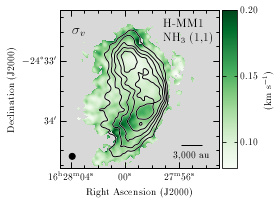

In [128]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_dv, figsize=(4, 4))
fig.show_colorscale(vmin=0.08, vmax=0.2, cmap='Greens', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'$\sigma_{v}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_ticks([0.1, 0.15, 0.2])
fig.colorbar.set_axis_label_text(r'(km s$^{-1}$)')

plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_dv.pdf', dpi=100)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greens").copy()
  cm.set_bad(color)


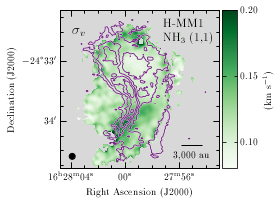

In [129]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_dv, figsize=(4, 4))
fig.show_colorscale(vmin=0.08, vmax=0.2, cmap='Greens', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True, do_contour=False)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'$\sigma_{v}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_ticks([0.1, 0.15, 0.2])
fig.colorbar.set_axis_label_text(r'(km s$^{-1}$)')

cont_CH3OH = np.arange(1, 12, 2)*0.015

fig.show_contour('data/H-MM1_CH3OH_TdV.fits', levels=cont_CH3OH, colors='white', linewidths=1.5)
fig.show_contour('data/H-MM1_CH3OH_TdV.fits', levels=cont_CH3OH, colors='#762a83', linewidths=1)

plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_dv_CH3OH.pdf', dpi=100)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greens").copy()
  cm.set_bad(color)


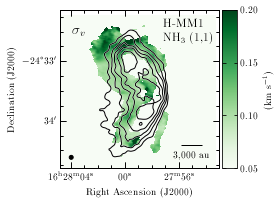

In [90]:
text_color = 'black'

fig = aplpy.FITSFigure('fits/H-MM1_CH3OH_sigma_v.fits', figsize=(4, 4))
fig.show_colorscale(vmin=0.05, vmax=0.2, cmap='Greens', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'$\sigma_{v}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_ticks([0.05, 0.1, 0.15, 0.2])
fig.colorbar.set_axis_label_text(r'(km s$^{-1}$)')
plt.tight_layout()                                                      
#
# fig.savefig('figs/H-MM1_CH3OH_dv.pdf', dpi=100)

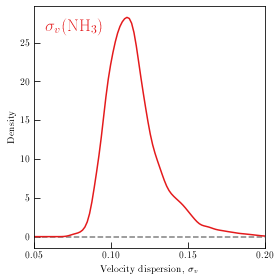

In [14]:
xrange = np.array([0.05, 0.2])

NH3_dv = fits.getdata(file_NH3_dv)
NH3_edv = fits.getdata(file_NH3_edv)
gd_dv = np.isfinite(NH3_dv)
wt = 1 / NH3_dv[gd_dv]**2
#
kde_dv = stats.gaussian_kde(NH3_dv[gd_dv], weights=wt)
x_sample = np.linspace(xrange[0], xrange[1], num=100)
dv_sample = np.reshape(kde_dv(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, dv_sample, color=color_kde[0], label=r'$\sigma_v$')
#
ax.text(0.05, 0.9,  r'$\sigma_v$(NH$_3$)', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)
ax.set_xlabel(r"Velocity dispersion, $\sigma_{v}$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)

ax.set_xticks([0.05, 0.1, 0.15, 0.2])
# ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
plt.tight_layout()                                                      
fig.savefig('figs/H-MM1_NH3_dv_KDE.pdf', dpi=100)

## Kinetic Temperature vs Column Density

In [15]:
gd_Tk_H2 = np.isfinite(N_H2_22 * tk)
gd_Tk_NH3 = np.isfinite(N_NH3_14 * tk)

In [16]:
np.min(tk[gd_Tk_H2]), np.max(tk[gd_Tk_H2])

(8.185523014473, 17.105335801952823)

In [17]:
# First binning on Tk vs N(NH3)
bin_means_Tk_NH3, bin_edges_Tk_NH3, binnumber_Tk_NH3 = stats.binned_statistic(
    N_NH3_14[gd_Tk_NH3], tk[gd_Tk_NH3], 
    statistic='mean', bins=15)

bin_ctr_Tk_NH3 = 0.5 * (bin_edges_Tk_NH3[1:] + bin_edges_Tk_NH3[:-1])

# Now binning on Tk vs H2
bin_means_Tk_H2, bin_edges_Tk_H2, binnumber_Tk_H2 = stats.binned_statistic(
    N_H2_22[gd_Tk_H2], tk[gd_Tk_H2],
    statistic='mean', bins=15)

bin_ctr_Tk_H2 = 0.5 * (bin_edges_Tk_H2[1:] + bin_edges_Tk_H2[:-1])

#
# 2-D KDE
# 
xx_Tk_NH3, yy_Tk_NH3, Tk_NH3_kde = hmm1_kde(
    N_NH3_14[gd_Tk_NH3], tk[gd_Tk_NH3], 
    xmin=1.2, xmax=11.5, 
    ymin=8, ymax=18.0, 
    get_XY=True)

xx_Tk_H2, yy_Tk_H2, Tk_H2_kde = hmm1_kde(
    N_H2_22[gd_Tk_H2], tk[gd_Tk_H2], 
    xmin=0, xmax=6.5, 
    ymin=8, ymax=18.0, 
    get_XY=True)

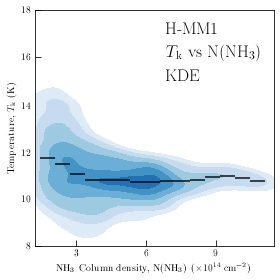

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
levels = levels_norm * Tk_NH3_kde.max()
cfset = ax.contourf(xx_Tk_NH3, yy_Tk_NH3, Tk_NH3_kde, colors=color_levels2, zorder=2,
                    levels=levels_norm_l * Tk_NH3_kde.max())

# binned values
ax.hlines(bin_means_Tk_NH3, bin_edges_Tk_NH3[:-1], bin_edges_Tk_NH3[1:], 
          colors='black', lw=2, alpha=0.7)
ax.set_xlim(range_N11)

ax.set_xlabel(r"NH$_3$ Column density, N(NH$_3$) ($\times 10^{14}$ cm$^{-2}$)")
ax.set_ylabel(r"Temperature, $T_{\rm k}$ (K)")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(NH$_3$)', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.7,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.set_xticks([3, 6, 9])
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Tk_Ncol_KDE.pdf', dpi=100)

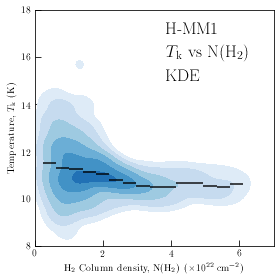

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * Tk_H2_kde.max()
cfset = ax.contourf(xx_Tk_H2, yy_Tk_H2, Tk_H2_kde, colors=color_levels2, zorder=2,
                    levels=levels_norm_l * Tk_H2_kde.max())
# binned values
ax.hlines(bin_means_Tk_H2, bin_edges_Tk_H2[:-1], bin_edges_Tk_H2[1:], 
          colors='black', lw=2, alpha=0.7)
ax.set_xlim(range_H2)

ax.set_xlabel(r"H$_2$ Column density, N(H$_2$) ($\times 10^{22}$ cm$^{-2}$)")
ax.set_ylabel(r"Temperature, $T_{\rm k}$ (K)")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(H$_2$)', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.7,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.set_xticks([0, 2, 4, 6])
plt.tight_layout()
#
fig.savefig('figs/H-MM1_NH3_Tk_H2_KDE.pdf', dpi=100)

## Abundances with respect to H$_2$
Calculation of the NH$_3$ and o-NH$_2$D abundance with respect of the H$_2$ column density derived with Spitzer

In [36]:
import emcee
def broken_line(x, a, b, c, x0):
    out = a*x + b
    gd_brk = (x > x0)
    out[gd_brk] = c*x[gd_brk] + b + x0 * (a - c)
    return out

def log_prior(theta):
    a, b, c, x0 = theta
    if 0.1 < a < 20. and -10.0 < b < 10.0 and \
    -1.0 < c < 3.0 and 1.0 < x0 < 4.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    a, b, c, x0 = theta
    model = a*x + b
    gd_brk = (x > x0)
    model[gd_brk] = c*x[gd_brk] + b + x0 * (a - c)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [61]:
pos = [1.975, 1.120, -0.110,2.575] + 1e-4 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, 
    args=(N_H2_22_gd, N_NH3_14_gd, eN_NH3_14_gd)
)
sampler.run_mcmc(pos, 15000, progress=True)

100%|████████████████████████████████████████████████████████████████████████| 15000/15000 [00:50<00:00, 298.33it/s]


State([[ 1.96373034  1.13619034 -0.09731997  2.57504028]
 [ 1.97132589  1.12910364 -0.10673388  2.5747775 ]
 [ 1.97645661  1.1214964  -0.11486597  2.57549885]
 [ 1.97232916  1.12548612 -0.11051801  2.57876701]
 [ 1.98640071  1.09921659 -0.11176744  2.57057392]
 [ 1.97553064  1.1155407  -0.10463209  2.57829855]
 [ 1.97281299  1.1201059  -0.10757317  2.57635974]
 [ 1.97118241  1.12619058 -0.10232852  2.57463785]
 [ 1.98539592  1.10210169 -0.1227115   2.57720576]
 [ 1.97318202  1.12345032 -0.11267786  2.57596984]
 [ 1.97303904  1.11996903 -0.10271838  2.5770233 ]
 [ 1.97280453  1.12497858 -0.10287059  2.57365249]
 [ 1.9730102   1.12966185 -0.107621    2.57085204]
 [ 1.97169058  1.12556475 -0.11020926  2.57970299]
 [ 1.97596044  1.11969836 -0.10879476  2.57172921]
 [ 1.97412493  1.11632052 -0.09390517  2.57271347]
 [ 1.96996302  1.12490373 -0.11144152  2.58070925]
 [ 1.9813215   1.11171796 -0.10092221  2.5680356 ]
 [ 1.96824424  1.12693304 -0.10192192  2.57273664]
 [ 1.97777715  1.11212203

[44.79841824 45.2683759  45.85593716 45.61510861]
25


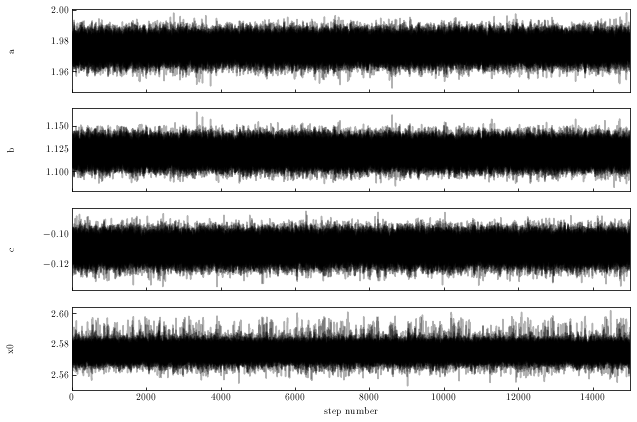

In [62]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c", "x0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
# Autocorrelation
tau = sampler.get_autocorr_time()
print(tau) # ~50
step_thin = 25
print(step_thin)

(29700, 4)


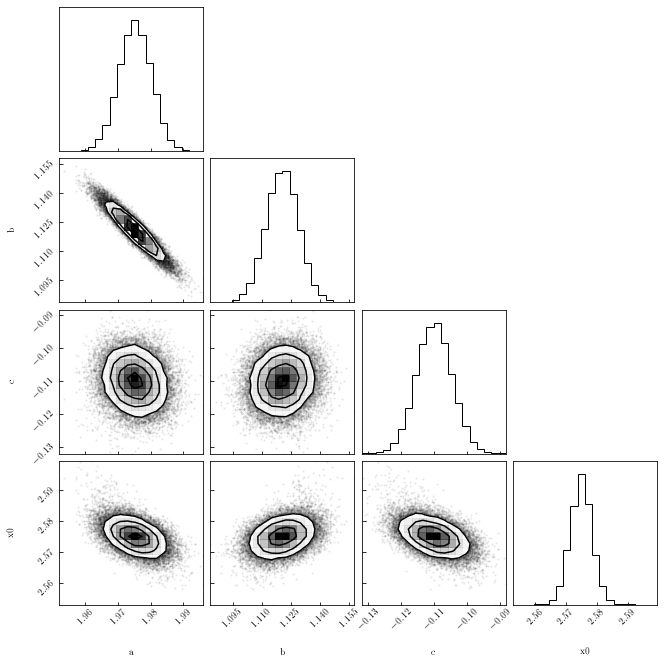

In [63]:
flat_samples = sampler.get_chain(discard=150, thin=step_thin, flat=True)
print(flat_samples.shape)
import corner

fig = corner.corner(
    flat_samples, labels=labels)

In [80]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    if i == 0:
        X_NH3_H2_fit = np.round(mcmc[1], decimals=3)
    print(txt)

inds = np.random.randint(len(flat_samples), size=100)

\mathrm{a} = 1.975_{-0.005}^{0.005}
\mathrm{b} = 1.121_{-0.008}^{0.008}
\mathrm{c} = -0.110_{-0.005}^{0.005}
\mathrm{x0} = 2.575_{-0.004}^{0.003}


/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_59094/886191678.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


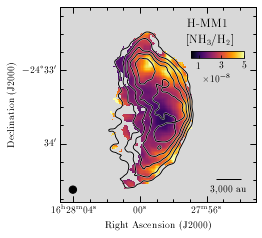

In [82]:
text_color = 'black'
# fig = aplpy.FITSFigure(hdu_NH3_H2_regrid, figsize=(4, 4))
fig = aplpy.FITSFigure(hdu_NH3_H2_8, figsize=(4, 4))
#
fig.show_colorscale(vmin=0.3, vmax=5, cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'[NH$_3$/H$_2$]', relative=True, 
                horizontalalignment='left', color=text_color, size=12)

fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([1, 3, 5])
fig.colorbar.set_axis_label_text(r'$\times10^{-8}$')
plt.tight_layout()
#
fig.savefig('figs/H-MM1_NH3_H2_ratio.pdf', dpi=200)

In [83]:
X_NH3_xrange = np.array([0., 7.0])

kde_NH3_H2 = stats.gaussian_kde(X_NH3_H2_gd)

x_sample = np.linspace(X_NH3_xrange[0], X_NH3_xrange[1], num=500)
X_NH3_H2_sample = np.reshape(kde_NH3_H2(x_sample).T, x_sample.shape)

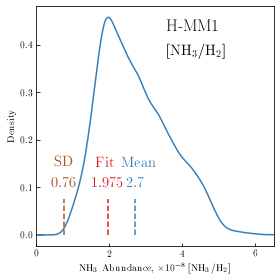

In [86]:
#########
### NH3/H2
#########
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, X_NH3_H2_sample, color=color_kde[1], label=r'$\sigma_v$')
#
ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'[NH$_3$/H$_2$]', color='black', 
        transform=ax.transAxes, size=15, weight=60)

ax.set_xlabel(r"NH$_3$ Abundance, $\times 10^{-8}$ [NH$_3$/H$_2$]")
ax.set_ylabel(r"Density")
ax.set_xlim([0.0, 6.5])

# add vertical markers with mean values, plus text
ax.vlines(X_NH3_SD, ymin=0, ymax=0.075, color=color_kde[2], linestyle='--')
ax.text(X_NH3_SD, 0.1, X_NH3_SD , color=color_kde[2], horizontalalignment='center', size=15, weight=60)
ax.text(X_NH3_SD, 0.145, r'SD' , color=color_kde[2], horizontalalignment='center', size=15, weight=60)

# add vertical markers with mean values, plus text
ax.vlines(X_NH3_H2_mean, ymin=0, ymax=0.075, color=color_kde[1], linestyle='--')
ax.text(X_NH3_H2_mean, 0.1, X_NH3_H2_mean , color=color_kde[1], horizontalalignment='center', size=15, weight=60)
ax.text(X_NH3_H2_mean + 0.1, 0.145, r'Mean' , color=color_kde[1], horizontalalignment='center', size=15, weight=60)

# add vertical markers with mean values, plus text
# X_NH3_H2_fit = 2.04
ax.vlines(X_NH3_H2_fit, ymin=0, ymax=0.075, color=color_kde[0], linestyle='--')
ax.text(X_NH3_H2_fit, 0.1, X_NH3_H2_fit , color=color_kde[0], horizontalalignment='center', size=15, weight=60)
ax.text(X_NH3_H2_fit - 0.1, 0.145, r'Fit' , color=color_kde[0], horizontalalignment='center', size=15, weight=60)

ax.set_xticks([0., 2, 4, 6])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
# ax.set_yticks([0, 0.015, 0.030, 0.045])
plt.tight_layout()
fig.savefig('figs/H-MM1_X_NH3_H2_kde.pdf', dpi=100)

In [25]:
bin_means_X_NH3, bin_edges_X_NH3, binnumber_X_NH3 = stats.binned_statistic(
    N_H2_22_gd, N_NH3_14_gd,
    statistic='mean', bins=15)#, range=range_H2)
bin_ctr_X_NH3 = 0.5 * (bin_edges_X_NH3[1:] + bin_edges_X_NH3[:-1])

xx, yy, NH3_H2_kde = hmm1_kde(N_H2_22_gd, N_NH3_14_gd,
                              xmin=0, xmax=6.5, 
                              ymin=1, ymax=11.3, 
                              get_XY=True)

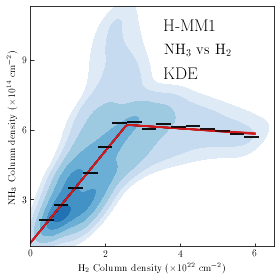

In [85]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * NH3_H2_kde.max()
cfset = ax.contourf(xx, yy, NH3_H2_kde, colors=color_levels2, zorder=2,
                    levels=levels_norm_l * NH3_H2_kde.max())

ax.set_xlabel(r"H$_2$ Column density ($\times 10^{22}$ cm$^{-2}$)")
ax.set_ylabel(r"NH$_3$ Column density ($\times 10^{14}$ cm$^{-2}$)")

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'NH$_3$ vs H$_2$', color='black', 
        transform=ax.transAxes, size=15, weight=60)
ax.text(0.55, 0.7,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)

x_sample_wide_fine = np.linspace(0, 6.0, 100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_sample_wide_fine, broken_line(x_sample_wide_fine, sample[0], sample[1], sample[2], sample[3]), 
             color_kde[0], alpha=0.05)

# binned values
ax.hlines(bin_means_X_NH3, bin_edges_X_NH3[:-1], bin_edges_X_NH3[1:], 
          colors='black', lw=2, alpha=0.7, zorder=11)

# x_sample = np.array([0, 3.0])
# ax.plot(x_sample, x_sample*res_X_NH3_cut.slope + res_X_NH3_cut.intercept, color='red')

# x_sample = np.array([0, 3.0])
# ax.plot(x_sample, x_sample*res_X_NH3_cut.slope + res_X_NH3_cut.intercept, color='black', linestyle='--')

# x_sample_wide = np.array([0, 6.0])
# ax.plot(x_sample_wide, x_sample_wide*X_NH3_SD + res_X_NH3_cut.intercept, color='red')

ax.set_xticks([0, 2, 4, 6])
ax.set_yticks([3, 6, 9])
ax.set_xlim([0, 6.5])
ax.set_ylim([1, 11.3])
ax.set_aspect('auto')

ax.hlines(bin_means_X_NH3, bin_edges_X_NH3[:-1], bin_edges_X_NH3[1:], 
          colors='black', lw=2, alpha=0.7)#, label='binned statistic of data')
plt.tight_layout()
fig.savefig('figs/H-MM1_NH3_v_H2_KDE.pdf')

### Export peak spectrum
For comparison with models, it is useful to export the NH$_3$ (1,1) and (2,2) spectra at the N(H$_2$) peak position.

In [30]:
file_cube_11 = 'data/H-MM1_NH3_11.fits'
file_cube_22 = 'data/H-MM1_NH3_22.fits'
ra_peak = 246.9939816*u.deg
dec_peak = -24.5615208*u.deg
# corresponding pixel in H2
x0_peak = 158
y0_peak = 135

Now, we import both cubes using spectral cube and extract the spectra.
Then plot them, and save them as an ASCII file.

In [31]:
from spectral_cube import SpectralCube as sc
cube_11 = sc.read(file_cube_11).with_spectral_unit(u.km / u.s, velocity_convention='radio')
cube_22 = sc.read(file_cube_22).with_spectral_unit(u.km / u.s, velocity_convention='radio')

spec_11 = cube_11[:, y0_peak, x0_peak]
spec_22 = cube_22[:, y0_peak, x0_peak]
velo_11 = cube_11.spectral_axis
velo_22 = cube_22.spectral_axis

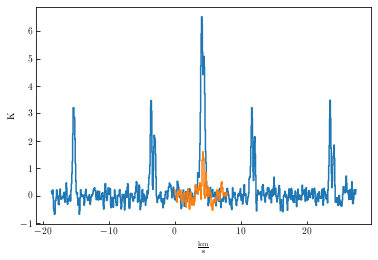

In [32]:
spec_11.quicklook()
spec_22.quicklook()

In [111]:
from astropy.io import ascii
from astropy.table import Table
data_11 = Table([velo_11, spec_11], names=['Velocity', 'Center'])
data_22 = Table([velo_22, spec_22], names=['Velocity', 'Center'])
ascii.write(data_11, 'data/H-MM1_NH3_11.data', overwrite=True)
ascii.write(data_22, 'data/H-MM1_NH3_22.data', overwrite=True)

In [114]:
file_model
model = ascii.read(file_model)

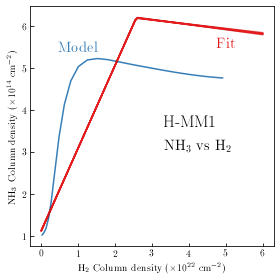

In [126]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(model['H2']*1e-22, model['NH3']*1e-14, color=color_kde[1])
x_sample_wide_fine = np.linspace(0, 6.0, 100)
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x_sample_wide_fine, broken_line(x_sample_wide_fine, sample[0], sample[1], sample[2], sample[3]), 
             color_kde[0], alpha=0.05)

ax.set_xlabel(r"H$_2$ Column density ($\times 10^{22}$ cm$^{-2}$)")
ax.set_ylabel(r"NH$_3$ Column density ($\times 10^{14}$ cm$^{-2}$)")

ax.text(0.55, 0.5,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.4,  r'NH$_3$ vs H$_2$', color='black', 
        transform=ax.transAxes, size=15, weight=60)

ax.text(5, 5.5, r'Fit' , color=color_kde[0], horizontalalignment='center', size=15, weight=60)
ax.text(1, 5.4, r'Model' , color=color_kde[1], horizontalalignment='center', size=15, weight=60)
plt.tight_layout()
fig.savefig('figs/H-MM1_NH3_v_H2_model_fit.pdf')